# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

## Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor


#from gensim.models import Word2Vec
#import gensim.downloader

import category_encoders as ce
import timeit
import time

/Applications/anaconda3/envs/Back_tester/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class car_appraisal():
    
    
    ### Создание экземпляра класса
    def __init__(self, df):
        self.data = df
        self.models_dict = {}
    
    @classmethod
    def instance_from_link(cls,link):
        return car_appraisal(
            df=pd.read_csv(link,header=0)
        )
        
    ### Обработка данных
    
    def check_duplicated(self):
        print(f'Количество дубликатов: {self.data.duplicated().sum()}')

    def check_misses(self):
        misses = pd.DataFrame(self.data.isna().sum().sort_values(ascending=False), columns=['misses'])
        misses['per'] = self.data.isna().mean().sort_values(ascending=False).apply(lambda x : '{:.2%}'.format(x))
        misses = misses.loc[misses['misses'] > 0]
        if misses.shape[0] > 0:
            return misses
        else:
            print('Пропусков в данных нет')
            
    ### plot
    
    def plot_hist(self, features=None, left_val = 0.05, right_val = 0.95, quantile_clac=True):
        assert features!=None, 'Не выбран столбец с данными'
        assert features in self.data.columns, f'Выбран неверный столбец с данными: {features}'
        
        if quantile_clac:
            left_val = self.data[features].quantile(left_val)
            right_val = self.data[features].quantile(right_val)
            
        
        fig = plt.figure(figsize=(12,8))
        ax1 = fig.add_subplot(211)
        ax1.set_title(f'Гистограмма распределения {features}')
        sns.histplot(self.data[features], color='blue')
        ax2 = fig.add_subplot(223)
        ax2.set_title(f'Левый хвост ')
        sns.histplot(self.data[features].loc[self.data[features] < left_val], color='blue')
        ax3 = fig.add_subplot(224)
        ax3.set_title(f'Правый хвост')
        sns.histplot(self.data[features].loc[self.data[features] > right_val], color='blue')
        plt.show()
        
    ### ML
    
    def features_target_splitter(self):
        self.features = self.data.drop(columns=['Price'])
        self.target = self.data['Price']
        
    def train_test_splitter(self):
        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(self.features,
                                                                            self.target, 
                                                                            test_size=.25,
                                                                            random_state=12345)
        
    def OHE_count(self):
        
        cat_cols = self.features.select_dtypes(include=["object"]).columns.tolist()
        num_cols = self.features.select_dtypes(exclude=["object"]).columns.tolist()
        
        cat_preprocessing_ohe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        )
        
        num_preprocessing = make_pipeline(StandardScaler())
        
        preprocessing_ohe = ColumnTransformer(
            [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing_ohe, cat_cols)]
        )
        self.features_train_OHE = preprocessing_ohe.fit_transform(self.features_train)

        #print('Количество колонок при использовании только OHE: {}'.format(len(features_train_OHE.columns)))
        
    def OHE_ME_endcoding(self):
        self.features_train_encoded = self.features_train
        self.features_test_encoded = self.features_test

        cat_cols = list(set(self.features_test_encoded.select_dtypes(include=["object"]).columns) - set(['Brand','Model']))
        nom_cols = ['Brand','Model']
        num_cols = self.features_test_encoded.select_dtypes(exclude=["object"]).columns.tolist()

        cat_preprocessing_ohe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore", sparse=False),
        )
        
        num_preprocessing = make_pipeline(StandardScaler())

        nom_preprocessing = make_pipeline(ce.m_estimate.MEstimateEncoder())

        preprocessing_full = ColumnTransformer(
            [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing_ohe, cat_cols), ('nom',nom_preprocessing, nom_cols)]
        )

        self.features_train_encoded = preprocessing_full.fit_transform(self.features_train_encoded, self.target_train)
        self.features_test_encoded = preprocessing_full.transform(self.features_test_encoded)


    @staticmethod
    def __rmse(target,predict):
        return mean_squared_error(target,predict, squared=False)
    
    @staticmethod
    def features_cat_cast(features):
        cat_features_val = features.select_dtypes(include=["object"]).columns.tolist()
        for feature in cat_features_val:
            features[feature] = pd.Series(features[feature], dtype="category")
        return features

    def LGBM(self):

        start_time = time.time()

        cat_features_val = self.features_train.select_dtypes(include=["object"]).columns.tolist()
        model = LGBMRegressor(random_state=1235)

        score = make_scorer(car_appraisal.__rmse, greater_is_better=False)

        param_grid = {
            'n_estimators' : [50, 100],
            'max_depth' : [7, 10],
        }

        self.LGBM_result = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=3,
            verbose=5,
            scoring=score,
            return_train_score=True,
        )
        for feature in cat_features_val:
            self.features_train[feature] = pd.Series(self.features_train[feature], dtype="category")

        self.LGBM_result.fit(self.features_train, self.target_train)

        self.models_dict['LGBM'] = {'time' : time.time() - start_time}
        self.models_dict['LGBM']['score'] = self.LGBM_result.best_score_ * (-1)

    def Catboost(self):

        start_time = time.time()
        
        cat_features_val = self.features.select_dtypes(include=["object"]).columns.tolist()
        model = CatBoostRegressor(random_state=12345,cat_features=cat_features_val, silent=True)
        
        param_grid = {
            'n_estimators' : [50, 100],
            'max_depth' : [7, 10],
        }
        
        
        score = make_scorer(car_appraisal.__rmse, greater_is_better=False)
        
        self.CatBoostRegressor_result = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=5,
            verbose=5,
            scoring=score,
            return_train_score=True,
        )


        self.CatBoostRegressor_result.fit(self.features_train, self.target_train)

        self.models_dict['Catboost'] = {'time' : time.time() - start_time}
        self.models_dict['Catboost']['score'] = self.CatBoostRegressor_result.best_score_ * (-1)
        
    def DecisionTree_regressor(self):

        start_time = time.time()

        model = DecisionTreeRegressor()
        
        score = make_scorer(car_appraisal.__rmse, greater_is_better=False)

        param_grid = {
            'max_depth' : [10, 15,25],
        }

        self.DecisionTreeRegressor_result = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=3,
            verbose=5,
            scoring=score,
            return_train_score=True
        )

        self.DecisionTreeRegressor_result.fit(self.features_train_encoded, self.target_train)

        
        self.models_dict['DecisionTree'] = {'time' : time.time() - start_time}
        self.models_dict['DecisionTree']['score'] = self.DecisionTreeRegressor_result.best_score_ * (-1)
    
        

In [4]:
try:
    auto_data = car_appraisal.instance_from_link(r'/Users/Desktop/practicum/math_2/autos.csv')
except:
    auto_data = car_appraisal.instance_from_link(r'https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
auto_data.data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак

- Price — цена (евро)

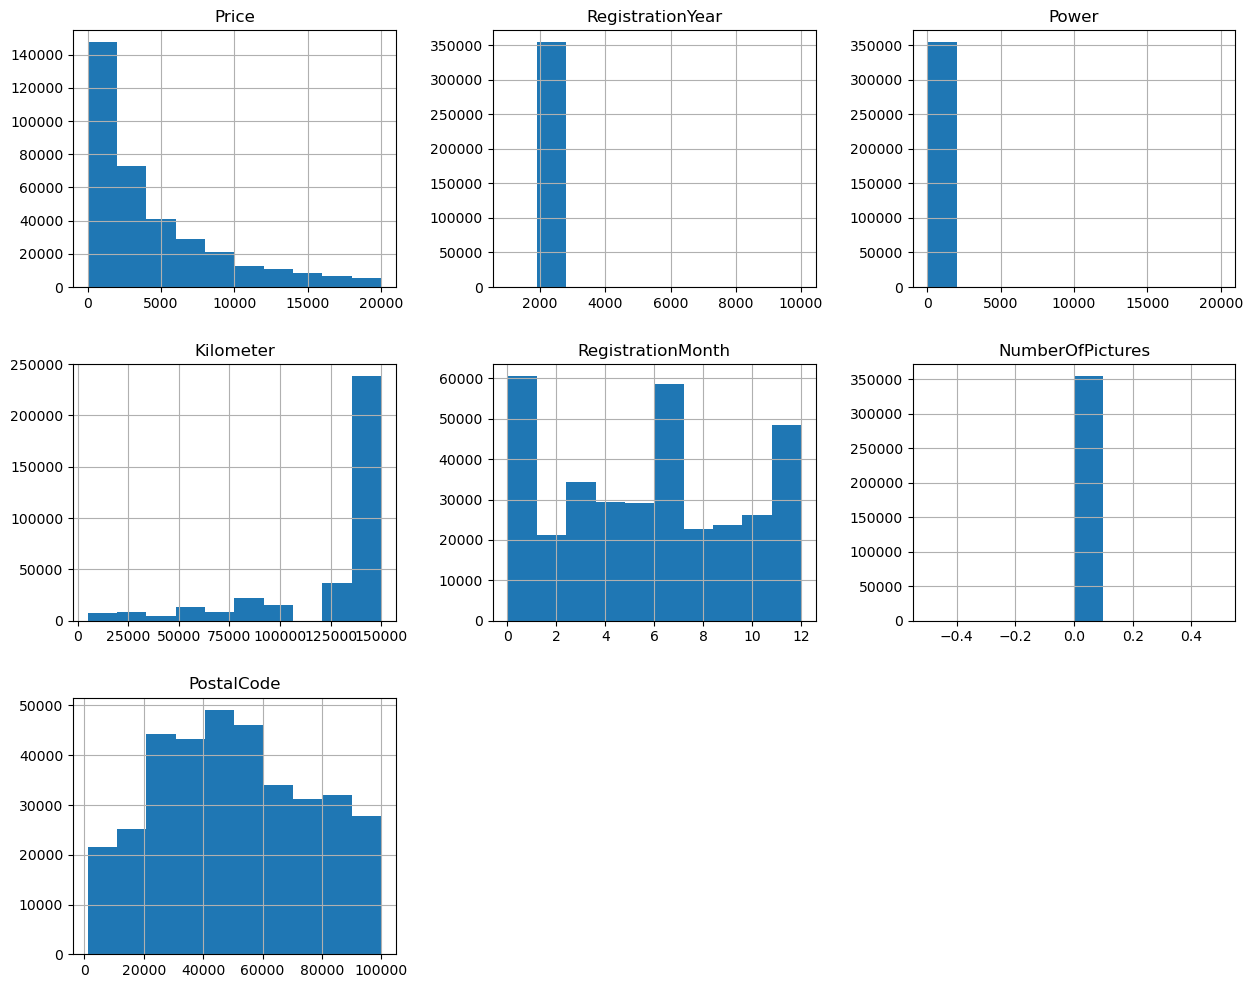

In [6]:
auto_data.data.hist(figsize=(15,12))
plt.show()

In [7]:
auto_data.data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Данные содержат в себе `354369` строк и `16` колонок, которые представляют собой 15 признаков и один целевой признак - `Price`. 

В данных содержатся неинформативные столбцы и аномалии:

К неинформативным столбцам можно отнести: 

1. RegistrationMonth;
2. NumberOfPictures (столбец, состоящий нулей);
3. PostalCode;
4. DateCrawled;
5. LastSeen;
6. DateCreated.

Аномалии содержаться в: 

1. Целевом признаке `Price`;
1. Признаках - `Power`, `RegistrationYear`

### Обработка неинформативных столбцов

Удалим неинформативные столбцы:

In [8]:
auto_data.data.drop(columns=['NumberOfPictures','PostalCode',\
                            'DateCrawled','LastSeen','RegistrationMonth',\
                            'DateCreated'], inplace=True)

### Проверка дубликатов

Проверим дубликаты:

In [9]:
auto_data.check_duplicated()

Количество дубликатов: 45040


In [10]:
auto_data.data[auto_data.data.duplicated(keep=False)].sort_values(
                                                    by=['Brand','RegistrationYear'])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
310656,10900,other,1958,manual,65,other,80000,petrol,alfa_romeo,NaN
311988,10900,other,1958,manual,65,other,80000,petrol,alfa_romeo,NaN
128248,10600,coupe,1970,manual,87,other,90000,petrol,alfa_romeo,no
155924,10600,coupe,1970,manual,87,other,90000,petrol,alfa_romeo,no
280439,16900,sedan,1973,manual,131,other,125000,petrol,alfa_romeo,no
...,...,...,...,...,...,...,...,...,...,...
120499,9999,NaN,2017,manual,0,NaN,150000,NaN,volvo,NaN
194624,530,NaN,2017,manual,144,850,150000,petrol,volvo,NaN
250922,0,NaN,2017,manual,116,v40,150000,NaN,volvo,no
287455,350,NaN,2017,manual,0,v40,150000,gasoline,volvo,yes


In [11]:
auto_data.data.drop_duplicates(inplace=True)

In [12]:
auto_data.check_duplicated()

Количество дубликатов: 0


### Пропуски

In [13]:
auto_data.check_misses()

,misses,per
Repaired,64558,20.87%
VehicleType,34559,11.17%
FuelType,30764,9.95%
Model,18361,5.94%
Gearbox,17207,5.56%


В данных содержится множество пропусков. Если их удалить, то потеряется большой процент тренировочных данных. К тому же это не решит главную проблему - рабочие данные, вероятно, тоже могут содержать пропуски. 

Заменим все пропуски на маркер - `unknown`. Пропуски в столбце `Repaired` заполним значением `no`, так как, вероятно, если этот параметр не указан, то машина не была в ремонте.

In [14]:
auto_data.data['Repaired'].value_counts()

no     211328
yes     33443
Name: Repaired, dtype: int64

In [15]:
auto_data.data['Repaired'].fillna('no', inplace=True)

In [16]:
auto_data.data['VehicleType'].fillna('unknown', inplace=True)

In [17]:
auto_data.data['Model'].fillna('unknown', inplace=True)

In [18]:
auto_data.data['Gearbox'].fillna('unknown', inplace=True)

In [19]:
auto_data.data['FuelType'].fillna('unknown', inplace=True)

In [20]:
auto_data.check_misses()

Пропусков в данных нет


### Аномалии

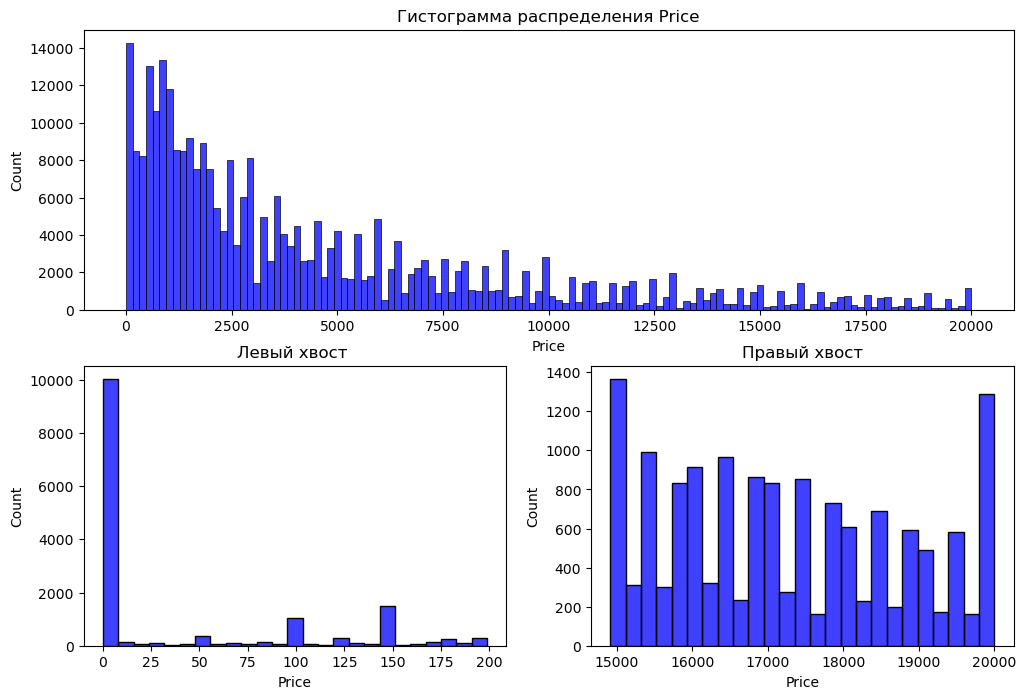

In [21]:
auto_data.plot_hist(features='Price')

В столбце `Price` содержится множество выбросов - наблюдаются нулевые и около нулевые значения. Удалим все значения меньше `100`.

In [22]:
auto_data.data = auto_data.data.query('Price >= 100')

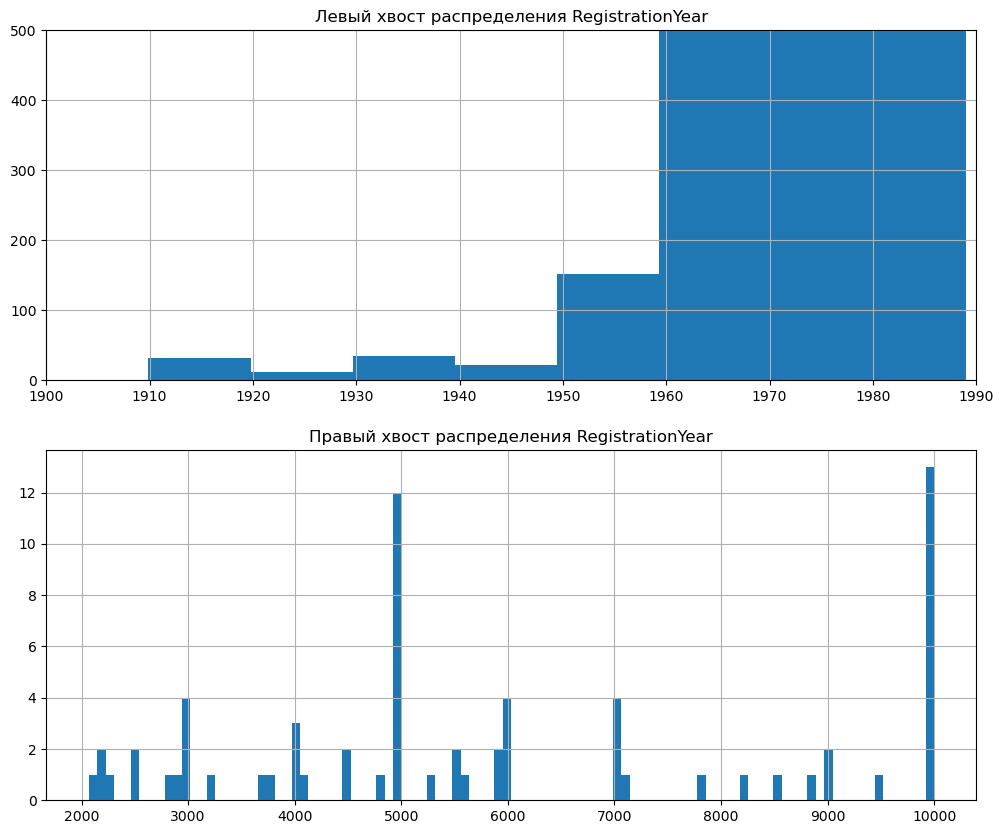

In [23]:
fig = plt.figure(figsize=(12,10))
plt.subplot(211)
ax1 = auto_data.data['RegistrationYear'].loc[auto_data.data['RegistrationYear'] < 1990].hist(bins=100)
ax1.set_ylim([0, 500])
ax1.set_xlim([1900, 1990])
plt.title('Левый хвост распределения RegistrationYear')
plt.subplot(212)
ax = auto_data.data['RegistrationYear'].loc[auto_data.data['RegistrationYear'] > 2022].hist(bins=100)
plt.title('Правый хвост распределения RegistrationYear')
plt.show()

В колонке с датой регистрации автомобиля множество аномалий:

1) Имеются автомобили, зарегистрированные в 1910-1950 годах;
2) Также имеются автомобили, зарегистрированные в `будущем`.

Удалим найденные аномалии.

In [24]:
auto_data.data = auto_data.data.query('RegistrationYear < 2016 & RegistrationYear > 1960')

Крайняя дата в данных - `'2016-04-07 14:36:58'`. 

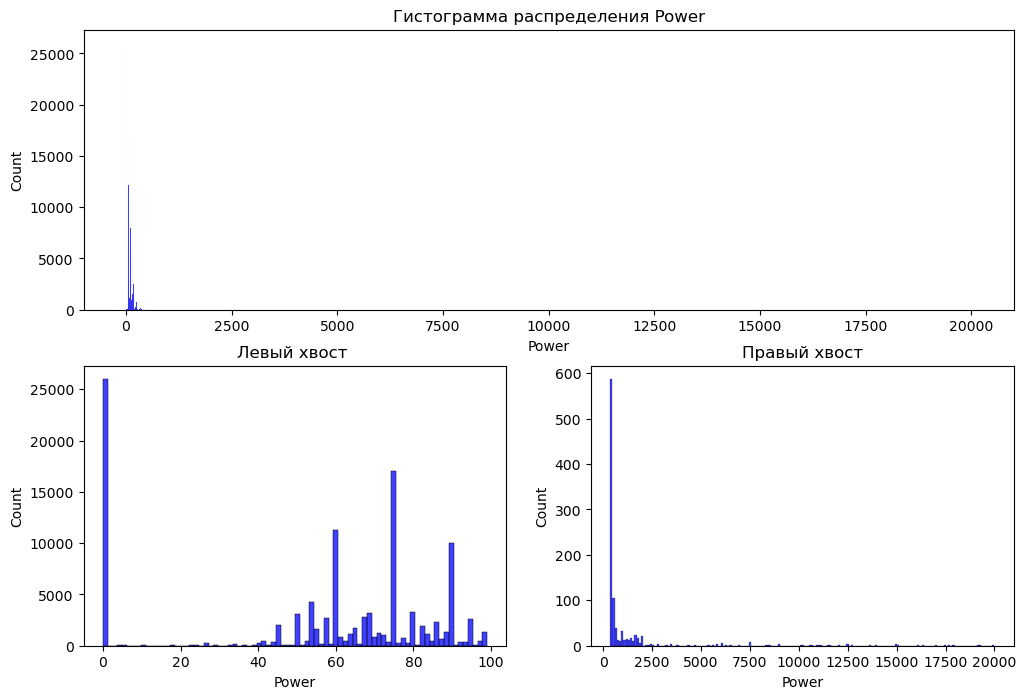

In [25]:
auto_data.plot_hist(features='Power',left_val= 100,right_val=350 ,quantile_clac=False)

В столбце `Power` найдено множество столбцов, где значения равны 0, либо больше адекватных значений. Обработаем найденные аномалии: 

In [26]:
auto_data.data = auto_data.data.loc[(auto_data.data['Power'] <= 400) & (auto_data.data['Power'] >= 40)]

In [27]:
auto_data.data.describe()

,Price,RegistrationYear,Power,Kilometer
count,248749.00000,248749.000000,248749.000000,248749.000000
mean,5011.89134,2002.668405,122.081785,127321.516870
std,4664.89056,6.180416,52.620279,37181.841466
min,100.00000,1961.000000,40.000000,5000.000000
25%,1450.00000,1999.000000,80.000000,125000.000000
50%,3390.00000,2003.000000,115.000000,150000.000000
75%,7250.00000,2007.000000,150.000000,150000.000000
max,20000.00000,2015.000000,400.000000,150000.000000


### Вывод:

Изначальные данные содержали в себе  `354369` строк и `16` колонок, которые представляют собой 15 признаков и один целевой признак - `Price`. 

В данных содержались неинформативные столбцы и аномалии:

К неинформативным столбцам можно отнести: 

1. RegistrationMonth;
2. NumberOfPictures (столбец, состоящий нулей);
3. PostalCode;
4. DateCrawled;
5. LastSeen;
6. DateCreated.

Аномалии содержаться в: 

1. Целевом признаке `Price`;
1. Признаках - `Power`, `RegistrationYear`

Пропуски содержались в следующих в колонках:

1. `Repaired` - `20.87`;
2. `VehicleType` - `11.17`;
3. `FuelType` - `9.95`;
4. `Model` - `5.94`;
5. `Gearbox` - `5.56`.

Была проделана следующая работа:

1. Были удалены неинформативные столбцы;
2. Обработаны и удалены аномальные значения;
3. Пропуски заполнены маркерами `unknown`.

## Обучение моделей

Разделим выборку на признаки и целевой признак:

In [28]:
auto_data.features_target_splitter()

Закодируем признаки с помощью `ordinal_encoder` и `one_hot_encoder`

In [29]:
auto_data.train_test_splitter()

In [30]:
auto_data.OHE_ME_endcoding()

/Applications/anaconda3/envs/Back_tester/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
auto_data.LGBM()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END max_depth=7, n_estimators=50;, score=(train=-1601.481, test=-1657.162) total time=   1.2s
[CV 2/3] END max_depth=7, n_estimators=50;, score=(train=-1607.014, test=-1643.313) total time=   0.8s
[CV 3/3] END max_depth=7, n_estimators=50;, score=(train=-1607.302, test=-1641.255) total time=   0.7s
[CV 1/3] END max_depth=7, n_estimators=100;, score=(train=-1535.932, test=-1617.735) total time=   0.9s
[CV 2/3] END max_depth=7, n_estimators=100;, score=(train=-1540.665, test=-1606.567) total time=   0.8s
[CV 3/3] END max_depth=7, n_estimators=100;, score=(train=-1541.224, test=-1600.179) total time=   0.8s
[CV 1/3] END max_depth=10, n_estimators=50;, score=(train=-1600.320, test=-1656.649) total time=   0.5s
[CV 2/3] END max_depth=10, n_estimators=50;, score=(train=-1604.444, test=-1641.495) total time=   0.5s
[CV 3/3] END max_depth=10, n_estimators=50;, score=(train=-1604.277, test=-1641.954) total time=   0.5s
[CV 1/3

In [32]:
auto_data.Catboost()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_depth=7, n_estimators=50;, score=(train=-1618.807, test=-1686.618) total time=   2.9s
[CV 2/5] END max_depth=7, n_estimators=50;, score=(train=-1611.651, test=-1658.164) total time=   1.8s
[CV 3/5] END max_depth=7, n_estimators=50;, score=(train=-1621.006, test=-1663.792) total time=   1.6s
[CV 4/5] END max_depth=7, n_estimators=50;, score=(train=-1625.113, test=-1654.370) total time=   1.6s
[CV 5/5] END max_depth=7, n_estimators=50;, score=(train=-1618.981, test=-1662.440) total time=   1.7s
[CV 1/5] END max_depth=7, n_estimators=100;, score=(train=-1555.135, test=-1648.324) total time=   3.1s
[CV 2/5] END max_depth=7, n_estimators=100;, score=(train=-1542.607, test=-1622.803) total time=   3.4s
[CV 3/5] END max_depth=7, n_estimators=100;, score=(train=-1553.119, test=-1630.253) total time=   3.6s
[CV 4/5] END max_depth=7, n_estimators=100;, score=(train=-1560.080, test=-1615.635) total time=   3.2s
[CV 5/5] 

In [33]:
auto_data.DecisionTree_regressor()

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END max_depth=10;, score=(train=-1765.434, test=-1915.254) total time=   0.5s
[CV 2/3] END max_depth=10;, score=(train=-1776.324, test=-1905.241) total time=   0.4s
[CV 3/3] END max_depth=10;, score=(train=-1779.748, test=-1907.961) total time=   0.4s
[CV 1/3] END max_depth=15;, score=(train=-1304.228, test=-1899.595) total time=   0.5s
[CV 2/3] END max_depth=15;, score=(train=-1322.946, test=-1879.605) total time=   0.5s
[CV 3/3] END max_depth=15;, score=(train=-1314.229, test=-1869.352) total time=   0.5s
[CV 1/3] END max_depth=25;, score=(train=-842.257, test=-2026.751) total time=   0.6s
[CV 2/3] END max_depth=25;, score=(train=-842.230, test=-2008.383) total time=   0.6s
[CV 3/3] END max_depth=25;, score=(train=-847.477, test=-1971.840) total time=   0.6s


## Анализ моделей

In [34]:
results = {
    'model' : 
        [*auto_data.models_dict.keys()],
    'score' : 
        [auto_data.models_dict[value]['score'] 
         for value in auto_data.models_dict.keys()],
    'time' : 
        [auto_data.models_dict[value]['time'] 
         for value in auto_data.models_dict.keys()],
    }
display(pd.DataFrame(results))

,model,score,time
0,LGBM,1607.974038,14.227784
1,Catboost,1599.772116,71.402050
2,DecisionTree,1882.850552,5.666869


Самая результативная модель - `Catboost`. Итоговая ошибка - `1616`. На втором месте `LGBM` с результатом `1624`. Однако время обучения составляет `81` секунду против `11` в пользу `LGBM`. Таким образом, `Catboost` лучшая модель по ошибке, и худшая по времени. В то время, как `LGBM` является более универсальной. Остановимся на данной модели.

Проверим модель на тестовой выборке:

In [35]:
pred = auto_data.LGBM_result.predict(car_appraisal.features_cat_cast(auto_data.features_test))
mean_squared_error(auto_data.target_test,pred, squared=False)

1603.943344740355

Итоговый результат удовлетворят условию.

## Вывод:

#### a. 

Изначальные данные содержали в себе  `354369` строк и `16` колонок, которые представляют собой 15 признаков и один целевой признак - `Price`. 

В данных содержались неинформативные столбцы и аномалии:

К неинформативным столбцам можно отнести: 

1. RegistrationMonth;
2. NumberOfPictures (столбец, состоящий нулей);
3. PostalCode;
4. DateCrawled;
5. LastSeen;
6. DateCreated.

Аномалии содержаться в: 

1. Целевом признаке `Price`;
1. Признаках - `Power`, `RegistrationYear`

Пропуски содержались в следующих в колонках:

1. `Repaired` - `20.87`;
2. `VehicleType` - `11.17`;
3. `FuelType` - `9.95`;
4. `Model` - `5.94`;
5. `Gearbox` - `5.56`.

Была проделана следующая работа:

1. Были удалены неинформативные столбцы;
2. Обработаны и удалены аномальные значения;
3. Пропуски заполнены маркерами `unknown`.

#### b.

Были обучены три модели: `LGBM`, `Catboost` и `DecisionTree_regressor`. На обучающей выборке были получены следующие результаты:

1. `LGBM` имеет RMSE `1607.97` и обучается за `11.59 сек.`;
2. `Catboost` имеет RMSE `1599.77` и обучается за `71.40 сек`;
3. `DecisionTree` имеет RMSE `1882.85` и обучается за `5.66 сек`.

Таким образом, наилучшая модель для поставленной задачи - `LGBM` c финальной оценкой на тестовой выборке `1603`